In [1]:
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
import numpy as np
import torchvision
from torchvision import *
from torch.utils.data import Dataset, DataLoader

import matplotlib.pyplot as plt
import time
import copy
import os

In [2]:
batch_size = 64
learning_rate = 0.0001

transforms = transforms.Compose(
[
    transforms.ToTensor()
])

train_dataset = datasets.ImageFolder(root='emotion5/train/', transform=transforms)
test_dataset = datasets.ImageFolder(root='emotion5/test/', transform=transforms)

train_dataloader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
test_dataloader = DataLoader(test_dataset, batch_size=batch_size, shuffle=True)
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')

In [3]:
def imshow(inp, title=None):
    
    inp = inp.cpu() if device else inp
    inp = inp.numpy().transpose((1, 2, 0))
    
    mean = np.array([0.485, 0.456, 0.406])
    std = np.array([0.229, 0.224, 0.225])
    inp = std * inp + mean
    inp = np.clip(inp, 0, 1)
    
    plt.imshow(inp)
    if title is not None:
        plt.title(title)
    plt.pause(0.001)

images-size: torch.Size([64, 3, 48, 48])
out-size: torch.Size([3, 402, 402])


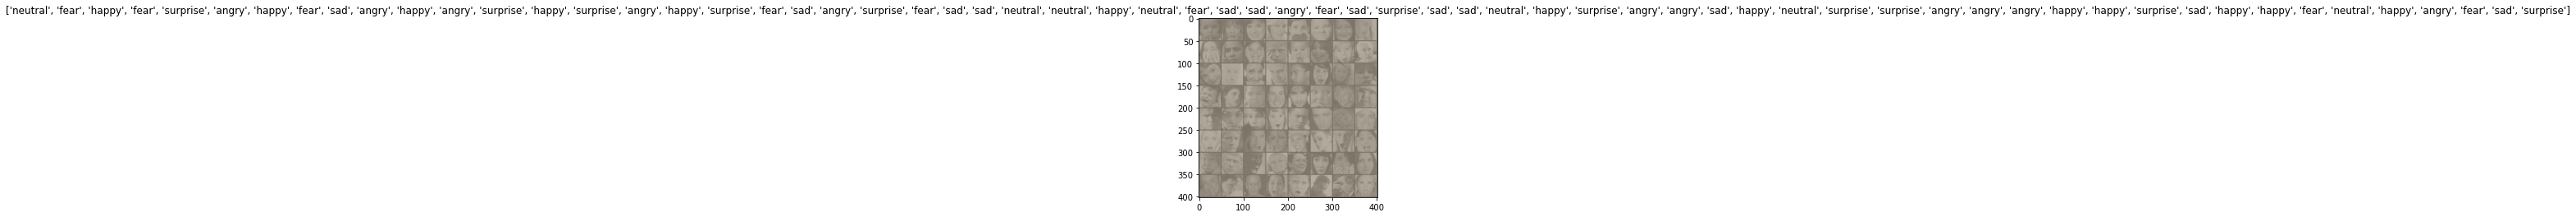

In [4]:
images, labels = next(iter(train_dataloader)) 
print("images-size:", images.shape)

out = torchvision.utils.make_grid(images)
print("out-size:", out.shape)

imshow(out, title=[train_dataset.classes[x] for x in labels])

In [5]:
net = models.resnet50(pretrained=True)
net = net.cuda() if device else net
net

ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): Bottleneck(
      (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn3): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (downsample): Sequential(
        (0): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 

In [6]:
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(net.parameters(), lr=0.0001, 
                 betas=(0.9, 0.999), 
                 eps=1e-08, 
                 weight_decay=0, 
                 amsgrad=False)

def accuracy(out, labels):
    _,pred = torch.max(out, dim=1)
    return torch.sum(pred==labels).item()

num_ftrs = net.fc.in_features
net.fc = nn.Linear(num_ftrs, 48)
net.fc = net.fc.cuda() if device else net.fc

In [7]:
n_epochs = 150
print_every = 10
valid_loss_min = np.Inf
val_loss = []
val_acc = []
train_loss = []
train_acc = []
total_step = len(train_dataloader)
for epoch in range(1, n_epochs+1):
    running_loss = 0.0
    correct = 0
    total=0
    print(f'Epoch {epoch}\n')
    for batch_idx, (data_, target_) in enumerate(train_dataloader):
        data_, target_ = data_.to(device), target_.to(device)
        optimizer.zero_grad()
        
        outputs = net(data_)
        loss = criterion(outputs, target_)
        loss.backward()
        optimizer.step()

        running_loss += loss.item()
        _,pred = torch.max(outputs, dim=1)
        correct += torch.sum(pred==target_).item()
        total += target_.size(0)
        if (batch_idx) % 20 == 0:
            print ('Epoch [{}/{}], Step [{}/{}], Loss: {:.4f}' 
                   .format(epoch, n_epochs, batch_idx, total_step, loss.item()))
    train_acc.append(100 * correct / total)
    train_loss.append(running_loss/total_step)
    print(f'\ntrain-loss: {np.mean(train_loss):.4f}, train-acc: {(100 * correct/total):.4f}')
    batch_loss = 0
    total_t=0
    correct_t=0
    with torch.no_grad():
        net.eval()
        for data_t, target_t in (test_dataloader):
            data_t, target_t = data_t.to(device), target_t.to(device)
            outputs_t = net(data_t)
            loss_t = criterion(outputs_t, target_t)
            batch_loss += loss_t.item()
            _,pred_t = torch.max(outputs_t, dim=1)
            correct_t += torch.sum(pred_t==target_t).item()
            total_t += target_t.size(0)
        val_acc.append(100 * correct_t/total_t)
        val_loss.append(batch_loss/len(test_dataloader))
        network_learned = batch_loss < valid_loss_min
        print(f'validation loss: {np.mean(val_loss):.4f}, validation acc: {(100 * correct_t/total_t):.4f}\n')

        
        if network_learned:
            valid_loss_min = batch_loss
            torch.save(net.state_dict(), 'Resnet5_50_adam_batch128_learninglr0001_nnlinear48.pt')
            print('Improvement-Detected, save-model')
    net.train()

Epoch 1

Epoch [1/150], Step [0/442], Loss: 3.9014
Epoch [1/150], Step [20/442], Loss: 3.3355
Epoch [1/150], Step [40/442], Loss: 3.1406
Epoch [1/150], Step [60/442], Loss: 2.4323
Epoch [1/150], Step [80/442], Loss: 1.7581
Epoch [1/150], Step [100/442], Loss: 1.8949
Epoch [1/150], Step [120/442], Loss: 1.9834
Epoch [1/150], Step [140/442], Loss: 1.5230
Epoch [1/150], Step [160/442], Loss: 1.6791
Epoch [1/150], Step [180/442], Loss: 1.3563
Epoch [1/150], Step [200/442], Loss: 1.7103
Epoch [1/150], Step [220/442], Loss: 1.6807
Epoch [1/150], Step [240/442], Loss: 1.3659
Epoch [1/150], Step [260/442], Loss: 1.7459
Epoch [1/150], Step [280/442], Loss: 1.0842
Epoch [1/150], Step [300/442], Loss: 1.3686
Epoch [1/150], Step [320/442], Loss: 1.1630
Epoch [1/150], Step [340/442], Loss: 0.9550
Epoch [1/150], Step [360/442], Loss: 1.2447
Epoch [1/150], Step [380/442], Loss: 1.5312
Epoch [1/150], Step [400/442], Loss: 1.4759
Epoch [1/150], Step [420/442], Loss: 1.1667
Epoch [1/150], Step [440/442]

Epoch [8/150], Step [180/442], Loss: 0.1040
Epoch [8/150], Step [200/442], Loss: 0.1342
Epoch [8/150], Step [220/442], Loss: 0.2174
Epoch [8/150], Step [240/442], Loss: 0.0623
Epoch [8/150], Step [260/442], Loss: 0.1357
Epoch [8/150], Step [280/442], Loss: 0.1436
Epoch [8/150], Step [300/442], Loss: 0.1628
Epoch [8/150], Step [320/442], Loss: 0.1707
Epoch [8/150], Step [340/442], Loss: 0.2263
Epoch [8/150], Step [360/442], Loss: 0.1261
Epoch [8/150], Step [380/442], Loss: 0.1001
Epoch [8/150], Step [400/442], Loss: 0.1269
Epoch [8/150], Step [420/442], Loss: 0.2814
Epoch [8/150], Step [440/442], Loss: 0.1417

train-loss: 0.6078, train-acc: 94.7865
validation loss: 1.4388, validation acc: 62.0065

Epoch 9

Epoch [9/150], Step [0/442], Loss: 0.0982
Epoch [9/150], Step [20/442], Loss: 0.0472
Epoch [9/150], Step [40/442], Loss: 0.0612
Epoch [9/150], Step [60/442], Loss: 0.0377
Epoch [9/150], Step [80/442], Loss: 0.0684
Epoch [9/150], Step [100/442], Loss: 0.0822
Epoch [9/150], Step [120/44

Epoch [15/150], Step [340/442], Loss: 0.0510
Epoch [15/150], Step [360/442], Loss: 0.2181
Epoch [15/150], Step [380/442], Loss: 0.0578
Epoch [15/150], Step [400/442], Loss: 0.0976
Epoch [15/150], Step [420/442], Loss: 0.0754
Epoch [15/150], Step [440/442], Loss: 0.0803

train-loss: 0.3716, train-acc: 97.1704
validation loss: 1.6759, validation acc: 63.0961

Epoch 16

Epoch [16/150], Step [0/442], Loss: 0.0842
Epoch [16/150], Step [20/442], Loss: 0.0672
Epoch [16/150], Step [40/442], Loss: 0.0583
Epoch [16/150], Step [60/442], Loss: 0.0266
Epoch [16/150], Step [80/442], Loss: 0.0953
Epoch [16/150], Step [100/442], Loss: 0.0814
Epoch [16/150], Step [120/442], Loss: 0.0521
Epoch [16/150], Step [140/442], Loss: 0.0399
Epoch [16/150], Step [160/442], Loss: 0.0174
Epoch [16/150], Step [180/442], Loss: 0.0748
Epoch [16/150], Step [200/442], Loss: 0.0299
Epoch [16/150], Step [220/442], Loss: 0.0966
Epoch [16/150], Step [240/442], Loss: 0.1243
Epoch [16/150], Step [260/442], Loss: 0.1038
Epoch 

validation loss: 1.7949, validation acc: 63.1102

Epoch 23

Epoch [23/150], Step [0/442], Loss: 0.0797
Epoch [23/150], Step [20/442], Loss: 0.0919
Epoch [23/150], Step [40/442], Loss: 0.0629
Epoch [23/150], Step [60/442], Loss: 0.0154
Epoch [23/150], Step [80/442], Loss: 0.0698
Epoch [23/150], Step [100/442], Loss: 0.0190
Epoch [23/150], Step [120/442], Loss: 0.0413
Epoch [23/150], Step [140/442], Loss: 0.0222
Epoch [23/150], Step [160/442], Loss: 0.0202
Epoch [23/150], Step [180/442], Loss: 0.0049
Epoch [23/150], Step [200/442], Loss: 0.0345
Epoch [23/150], Step [220/442], Loss: 0.0509
Epoch [23/150], Step [240/442], Loss: 0.0409
Epoch [23/150], Step [260/442], Loss: 0.0367
Epoch [23/150], Step [280/442], Loss: 0.0516
Epoch [23/150], Step [300/442], Loss: 0.0438
Epoch [23/150], Step [320/442], Loss: 0.0672
Epoch [23/150], Step [340/442], Loss: 0.1634
Epoch [23/150], Step [360/442], Loss: 0.0486
Epoch [23/150], Step [380/442], Loss: 0.1104
Epoch [23/150], Step [400/442], Loss: 0.0452
E

Epoch [30/150], Step [120/442], Loss: 0.1542
Epoch [30/150], Step [140/442], Loss: 0.0315
Epoch [30/150], Step [160/442], Loss: 0.0104
Epoch [30/150], Step [180/442], Loss: 0.0187
Epoch [30/150], Step [200/442], Loss: 0.0325
Epoch [30/150], Step [220/442], Loss: 0.0067
Epoch [30/150], Step [240/442], Loss: 0.0333
Epoch [30/150], Step [260/442], Loss: 0.0365
Epoch [30/150], Step [280/442], Loss: 0.0205
Epoch [30/150], Step [300/442], Loss: 0.0149
Epoch [30/150], Step [320/442], Loss: 0.0578
Epoch [30/150], Step [340/442], Loss: 0.0075
Epoch [30/150], Step [360/442], Loss: 0.0252
Epoch [30/150], Step [380/442], Loss: 0.0064
Epoch [30/150], Step [400/442], Loss: 0.0687
Epoch [30/150], Step [420/442], Loss: 0.0975
Epoch [30/150], Step [440/442], Loss: 0.0045

train-loss: 0.2164, train-acc: 98.2987
validation loss: 1.8770, validation acc: 63.3083

Epoch 31

Epoch [31/150], Step [0/442], Loss: 0.0955
Epoch [31/150], Step [20/442], Loss: 0.0186
Epoch [31/150], Step [40/442], Loss: 0.0436
Epoc

Epoch [37/150], Step [260/442], Loss: 0.0743
Epoch [37/150], Step [280/442], Loss: 0.0061
Epoch [37/150], Step [300/442], Loss: 0.0105
Epoch [37/150], Step [320/442], Loss: 0.0523
Epoch [37/150], Step [340/442], Loss: 0.0218
Epoch [37/150], Step [360/442], Loss: 0.0304
Epoch [37/150], Step [380/442], Loss: 0.0794
Epoch [37/150], Step [400/442], Loss: 0.0354
Epoch [37/150], Step [420/442], Loss: 0.0569
Epoch [37/150], Step [440/442], Loss: 0.0326

train-loss: 0.1841, train-acc: 98.3447
validation loss: 1.9284, validation acc: 63.8885

Epoch 38

Epoch [38/150], Step [0/442], Loss: 0.0064
Epoch [38/150], Step [20/442], Loss: 0.0014
Epoch [38/150], Step [40/442], Loss: 0.0272
Epoch [38/150], Step [60/442], Loss: 0.0031
Epoch [38/150], Step [80/442], Loss: 0.0404
Epoch [38/150], Step [100/442], Loss: 0.0471
Epoch [38/150], Step [120/442], Loss: 0.0135
Epoch [38/150], Step [140/442], Loss: 0.0065
Epoch [38/150], Step [160/442], Loss: 0.0273
Epoch [38/150], Step [180/442], Loss: 0.0026
Epoch 

Epoch [44/150], Step [400/442], Loss: 0.0636
Epoch [44/150], Step [420/442], Loss: 0.0324
Epoch [44/150], Step [440/442], Loss: 0.1193

train-loss: 0.1611, train-acc: 98.7798
validation loss: 1.9642, validation acc: 63.6762

Epoch 45

Epoch [45/150], Step [0/442], Loss: 0.0398
Epoch [45/150], Step [20/442], Loss: 0.0270
Epoch [45/150], Step [40/442], Loss: 0.0311
Epoch [45/150], Step [60/442], Loss: 0.0400
Epoch [45/150], Step [80/442], Loss: 0.0041
Epoch [45/150], Step [100/442], Loss: 0.0176
Epoch [45/150], Step [120/442], Loss: 0.0342
Epoch [45/150], Step [140/442], Loss: 0.0122
Epoch [45/150], Step [160/442], Loss: 0.0076
Epoch [45/150], Step [180/442], Loss: 0.0776
Epoch [45/150], Step [200/442], Loss: 0.0139
Epoch [45/150], Step [220/442], Loss: 0.0062
Epoch [45/150], Step [240/442], Loss: 0.0045
Epoch [45/150], Step [260/442], Loss: 0.0025
Epoch [45/150], Step [280/442], Loss: 0.0153
Epoch [45/150], Step [300/442], Loss: 0.0264
Epoch [45/150], Step [320/442], Loss: 0.0138
Epoch 

Epoch [52/150], Step [40/442], Loss: 0.0108
Epoch [52/150], Step [60/442], Loss: 0.0022
Epoch [52/150], Step [80/442], Loss: 0.1196
Epoch [52/150], Step [100/442], Loss: 0.0059
Epoch [52/150], Step [120/442], Loss: 0.0070
Epoch [52/150], Step [140/442], Loss: 0.0185
Epoch [52/150], Step [160/442], Loss: 0.0140
Epoch [52/150], Step [180/442], Loss: 0.0008
Epoch [52/150], Step [200/442], Loss: 0.0791
Epoch [52/150], Step [220/442], Loss: 0.0280
Epoch [52/150], Step [240/442], Loss: 0.0065
Epoch [52/150], Step [260/442], Loss: 0.0225
Epoch [52/150], Step [280/442], Loss: 0.0642
Epoch [52/150], Step [300/442], Loss: 0.0071
Epoch [52/150], Step [320/442], Loss: 0.0269
Epoch [52/150], Step [340/442], Loss: 0.0129
Epoch [52/150], Step [360/442], Loss: 0.0462
Epoch [52/150], Step [380/442], Loss: 0.0095
Epoch [52/150], Step [400/442], Loss: 0.0022
Epoch [52/150], Step [420/442], Loss: 0.0104
Epoch [52/150], Step [440/442], Loss: 0.0687

train-loss: 0.1414, train-acc: 98.9460
validation loss: 2

Epoch [59/150], Step [180/442], Loss: 0.0510
Epoch [59/150], Step [200/442], Loss: 0.0288
Epoch [59/150], Step [220/442], Loss: 0.0636
Epoch [59/150], Step [240/442], Loss: 0.0321
Epoch [59/150], Step [260/442], Loss: 0.0180
Epoch [59/150], Step [280/442], Loss: 0.0061
Epoch [59/150], Step [300/442], Loss: 0.0079
Epoch [59/150], Step [320/442], Loss: 0.0153
Epoch [59/150], Step [340/442], Loss: 0.0060
Epoch [59/150], Step [360/442], Loss: 0.0366
Epoch [59/150], Step [380/442], Loss: 0.0092
Epoch [59/150], Step [400/442], Loss: 0.0055
Epoch [59/150], Step [420/442], Loss: 0.0814
Epoch [59/150], Step [440/442], Loss: 0.0096

train-loss: 0.1283, train-acc: 99.0061
validation loss: 2.0317, validation acc: 62.5018

Epoch 60

Epoch [60/150], Step [0/442], Loss: 0.0106
Epoch [60/150], Step [20/442], Loss: 0.0037
Epoch [60/150], Step [40/442], Loss: 0.0260
Epoch [60/150], Step [60/442], Loss: 0.0354
Epoch [60/150], Step [80/442], Loss: 0.0260
Epoch [60/150], Step [100/442], Loss: 0.0096
Epoch 

Epoch [66/150], Step [320/442], Loss: 0.0247
Epoch [66/150], Step [340/442], Loss: 0.0858
Epoch [66/150], Step [360/442], Loss: 0.0093
Epoch [66/150], Step [380/442], Loss: 0.0450
Epoch [66/150], Step [400/442], Loss: 0.0071
Epoch [66/150], Step [420/442], Loss: 0.0581
Epoch [66/150], Step [440/442], Loss: 0.0080

train-loss: 0.1177, train-acc: 99.1087
validation loss: 2.0544, validation acc: 63.7045

Epoch 67

Epoch [67/150], Step [0/442], Loss: 0.0030
Epoch [67/150], Step [20/442], Loss: 0.0418
Epoch [67/150], Step [40/442], Loss: 0.1042
Epoch [67/150], Step [60/442], Loss: 0.0047
Epoch [67/150], Step [80/442], Loss: 0.0071
Epoch [67/150], Step [100/442], Loss: 0.0028
Epoch [67/150], Step [120/442], Loss: 0.0203
Epoch [67/150], Step [140/442], Loss: 0.0123
Epoch [67/150], Step [160/442], Loss: 0.0092
Epoch [67/150], Step [180/442], Loss: 0.0727
Epoch [67/150], Step [200/442], Loss: 0.0045
Epoch [67/150], Step [220/442], Loss: 0.0671
Epoch [67/150], Step [240/442], Loss: 0.0010
Epoch 

validation loss: 2.0748, validation acc: 63.9592

Epoch 74

Epoch [74/150], Step [0/442], Loss: 0.0360
Epoch [74/150], Step [20/442], Loss: 0.0044
Epoch [74/150], Step [40/442], Loss: 0.0819
Epoch [74/150], Step [60/442], Loss: 0.0030
Epoch [74/150], Step [80/442], Loss: 0.0315
Epoch [74/150], Step [100/442], Loss: 0.0174
Epoch [74/150], Step [120/442], Loss: 0.0212
Epoch [74/150], Step [140/442], Loss: 0.0264
Epoch [74/150], Step [160/442], Loss: 0.0755
Epoch [74/150], Step [180/442], Loss: 0.0097
Epoch [74/150], Step [200/442], Loss: 0.0243
Epoch [74/150], Step [220/442], Loss: 0.0347
Epoch [74/150], Step [240/442], Loss: 0.0287
Epoch [74/150], Step [260/442], Loss: 0.0078
Epoch [74/150], Step [280/442], Loss: 0.1091
Epoch [74/150], Step [300/442], Loss: 0.0337
Epoch [74/150], Step [320/442], Loss: 0.0047
Epoch [74/150], Step [340/442], Loss: 0.0315
Epoch [74/150], Step [360/442], Loss: 0.0179
Epoch [74/150], Step [380/442], Loss: 0.0061
Epoch [74/150], Step [400/442], Loss: 0.0055
E

Epoch [81/150], Step [120/442], Loss: 0.0245
Epoch [81/150], Step [140/442], Loss: 0.0057
Epoch [81/150], Step [160/442], Loss: 0.0026
Epoch [81/150], Step [180/442], Loss: 0.0018
Epoch [81/150], Step [200/442], Loss: 0.0747
Epoch [81/150], Step [220/442], Loss: 0.0530
Epoch [81/150], Step [240/442], Loss: 0.0243
Epoch [81/150], Step [260/442], Loss: 0.0043
Epoch [81/150], Step [280/442], Loss: 0.0149
Epoch [81/150], Step [300/442], Loss: 0.0023
Epoch [81/150], Step [320/442], Loss: 0.1129
Epoch [81/150], Step [340/442], Loss: 0.0234
Epoch [81/150], Step [360/442], Loss: 0.0845
Epoch [81/150], Step [380/442], Loss: 0.0024
Epoch [81/150], Step [400/442], Loss: 0.0425
Epoch [81/150], Step [420/442], Loss: 0.0232
Epoch [81/150], Step [440/442], Loss: 0.0224

train-loss: 0.1006, train-acc: 99.1617
validation loss: 2.0936, validation acc: 62.8414

Epoch 82

Epoch [82/150], Step [0/442], Loss: 0.0115
Epoch [82/150], Step [20/442], Loss: 0.0031
Epoch [82/150], Step [40/442], Loss: 0.0027
Epoc

Epoch [88/150], Step [260/442], Loss: 0.0007
Epoch [88/150], Step [280/442], Loss: 0.0465
Epoch [88/150], Step [300/442], Loss: 0.0143
Epoch [88/150], Step [320/442], Loss: 0.0046
Epoch [88/150], Step [340/442], Loss: 0.0134
Epoch [88/150], Step [360/442], Loss: 0.0053
Epoch [88/150], Step [380/442], Loss: 0.0079
Epoch [88/150], Step [400/442], Loss: 0.0120
Epoch [88/150], Step [420/442], Loss: 0.0068
Epoch [88/150], Step [440/442], Loss: 0.0287

train-loss: 0.0944, train-acc: 99.3952
validation loss: 2.1073, validation acc: 64.0158

Epoch 89

Epoch [89/150], Step [0/442], Loss: 0.0004
Epoch [89/150], Step [20/442], Loss: 0.0344
Epoch [89/150], Step [40/442], Loss: 0.0027
Epoch [89/150], Step [60/442], Loss: 0.0043
Epoch [89/150], Step [80/442], Loss: 0.0054
Epoch [89/150], Step [100/442], Loss: 0.0050
Epoch [89/150], Step [120/442], Loss: 0.0014
Epoch [89/150], Step [140/442], Loss: 0.0112
Epoch [89/150], Step [160/442], Loss: 0.0041
Epoch [89/150], Step [180/442], Loss: 0.0049
Epoch 

Epoch [95/150], Step [400/442], Loss: 0.0179
Epoch [95/150], Step [420/442], Loss: 0.0071
Epoch [95/150], Step [440/442], Loss: 0.0035

train-loss: 0.0890, train-acc: 99.4588
validation loss: 2.1216, validation acc: 63.4074

Epoch 96

Epoch [96/150], Step [0/442], Loss: 0.0016
Epoch [96/150], Step [20/442], Loss: 0.0098
Epoch [96/150], Step [40/442], Loss: 0.0049
Epoch [96/150], Step [60/442], Loss: 0.0021
Epoch [96/150], Step [80/442], Loss: 0.0023
Epoch [96/150], Step [100/442], Loss: 0.0115
Epoch [96/150], Step [120/442], Loss: 0.0143
Epoch [96/150], Step [140/442], Loss: 0.0008
Epoch [96/150], Step [160/442], Loss: 0.0100
Epoch [96/150], Step [180/442], Loss: 0.0002
Epoch [96/150], Step [200/442], Loss: 0.0117
Epoch [96/150], Step [220/442], Loss: 0.0022
Epoch [96/150], Step [240/442], Loss: 0.0130
Epoch [96/150], Step [260/442], Loss: 0.0170
Epoch [96/150], Step [280/442], Loss: 0.0028
Epoch [96/150], Step [300/442], Loss: 0.0121
Epoch [96/150], Step [320/442], Loss: 0.0276
Epoch 

Epoch [103/150], Step [20/442], Loss: 0.0011
Epoch [103/150], Step [40/442], Loss: 0.0959
Epoch [103/150], Step [60/442], Loss: 0.0231
Epoch [103/150], Step [80/442], Loss: 0.0017
Epoch [103/150], Step [100/442], Loss: 0.0749
Epoch [103/150], Step [120/442], Loss: 0.0120
Epoch [103/150], Step [140/442], Loss: 0.0644
Epoch [103/150], Step [160/442], Loss: 0.0150
Epoch [103/150], Step [180/442], Loss: 0.0007
Epoch [103/150], Step [200/442], Loss: 0.0458
Epoch [103/150], Step [220/442], Loss: 0.1439
Epoch [103/150], Step [240/442], Loss: 0.0007
Epoch [103/150], Step [260/442], Loss: 0.0095
Epoch [103/150], Step [280/442], Loss: 0.0590
Epoch [103/150], Step [300/442], Loss: 0.0025
Epoch [103/150], Step [320/442], Loss: 0.0009
Epoch [103/150], Step [340/442], Loss: 0.0166
Epoch [103/150], Step [360/442], Loss: 0.0218
Epoch [103/150], Step [380/442], Loss: 0.0042
Epoch [103/150], Step [400/442], Loss: 0.0663
Epoch [103/150], Step [420/442], Loss: 0.0019
Epoch [103/150], Step [440/442], Loss:

Epoch [110/150], Step [80/442], Loss: 0.0411
Epoch [110/150], Step [100/442], Loss: 0.0120
Epoch [110/150], Step [120/442], Loss: 0.0684
Epoch [110/150], Step [140/442], Loss: 0.0010
Epoch [110/150], Step [160/442], Loss: 0.1517
Epoch [110/150], Step [180/442], Loss: 0.1771
Epoch [110/150], Step [200/442], Loss: 0.0337
Epoch [110/150], Step [220/442], Loss: 0.0025
Epoch [110/150], Step [240/442], Loss: 0.0333
Epoch [110/150], Step [260/442], Loss: 0.0020
Epoch [110/150], Step [280/442], Loss: 0.0270
Epoch [110/150], Step [300/442], Loss: 0.0358
Epoch [110/150], Step [320/442], Loss: 0.0388
Epoch [110/150], Step [340/442], Loss: 0.0024
Epoch [110/150], Step [360/442], Loss: 0.0140
Epoch [110/150], Step [380/442], Loss: 0.0219
Epoch [110/150], Step [400/442], Loss: 0.0464
Epoch [110/150], Step [420/442], Loss: 0.0007
Epoch [110/150], Step [440/442], Loss: 0.0278

train-loss: 0.0796, train-acc: 98.9849
validation loss: 2.1527, validation acc: 63.0678

Epoch 111

Epoch [111/150], Step [0/4

Epoch [117/150], Step [140/442], Loss: 0.1391
Epoch [117/150], Step [160/442], Loss: 0.0055
Epoch [117/150], Step [180/442], Loss: 0.0084
Epoch [117/150], Step [200/442], Loss: 0.0253
Epoch [117/150], Step [220/442], Loss: 0.0012
Epoch [117/150], Step [240/442], Loss: 0.0022
Epoch [117/150], Step [260/442], Loss: 0.0250
Epoch [117/150], Step [280/442], Loss: 0.0316
Epoch [117/150], Step [300/442], Loss: 0.0021
Epoch [117/150], Step [320/442], Loss: 0.0339
Epoch [117/150], Step [340/442], Loss: 0.0015
Epoch [117/150], Step [360/442], Loss: 0.0464
Epoch [117/150], Step [380/442], Loss: 0.0386
Epoch [117/150], Step [400/442], Loss: 0.0008
Epoch [117/150], Step [420/442], Loss: 0.0120
Epoch [117/150], Step [440/442], Loss: 0.0008

train-loss: 0.0760, train-acc: 99.3846
validation loss: 2.1651, validation acc: 63.8036

Epoch 118

Epoch [118/150], Step [0/442], Loss: 0.0018
Epoch [118/150], Step [20/442], Loss: 0.0013
Epoch [118/150], Step [40/442], Loss: 0.0004
Epoch [118/150], Step [60/442

Epoch [124/150], Step [200/442], Loss: 0.0004
Epoch [124/150], Step [220/442], Loss: 0.1799
Epoch [124/150], Step [240/442], Loss: 0.0017
Epoch [124/150], Step [260/442], Loss: 0.0055
Epoch [124/150], Step [280/442], Loss: 0.0012
Epoch [124/150], Step [300/442], Loss: 0.0011
Epoch [124/150], Step [320/442], Loss: 0.0038
Epoch [124/150], Step [340/442], Loss: 0.0133
Epoch [124/150], Step [360/442], Loss: 0.0201
Epoch [124/150], Step [380/442], Loss: 0.0012
Epoch [124/150], Step [400/442], Loss: 0.0936
Epoch [124/150], Step [420/442], Loss: 0.0192
Epoch [124/150], Step [440/442], Loss: 0.0340

train-loss: 0.0727, train-acc: 99.4376
validation loss: 2.1761, validation acc: 63.8602

Epoch 125

Epoch [125/150], Step [0/442], Loss: 0.0082
Epoch [125/150], Step [20/442], Loss: 0.0169
Epoch [125/150], Step [40/442], Loss: 0.0089
Epoch [125/150], Step [60/442], Loss: 0.0246
Epoch [125/150], Step [80/442], Loss: 0.0188
Epoch [125/150], Step [100/442], Loss: 0.0210
Epoch [125/150], Step [120/442]

Epoch [131/150], Step [260/442], Loss: 0.0169
Epoch [131/150], Step [280/442], Loss: 0.1499
Epoch [131/150], Step [300/442], Loss: 0.0025
Epoch [131/150], Step [320/442], Loss: 0.0026
Epoch [131/150], Step [340/442], Loss: 0.0125
Epoch [131/150], Step [360/442], Loss: 0.0017
Epoch [131/150], Step [380/442], Loss: 0.0789
Epoch [131/150], Step [400/442], Loss: 0.0379
Epoch [131/150], Step [420/442], Loss: 0.1209
Epoch [131/150], Step [440/442], Loss: 0.0019

train-loss: 0.0698, train-acc: 99.1228
validation loss: 2.1859, validation acc: 63.1385

Epoch 132

Epoch [132/150], Step [0/442], Loss: 0.0121
Epoch [132/150], Step [20/442], Loss: 0.0081
Epoch [132/150], Step [40/442], Loss: 0.0004
Epoch [132/150], Step [60/442], Loss: 0.0257
Epoch [132/150], Step [80/442], Loss: 0.0090
Epoch [132/150], Step [100/442], Loss: 0.0185
Epoch [132/150], Step [120/442], Loss: 0.0008
Epoch [132/150], Step [140/442], Loss: 0.0676
Epoch [132/150], Step [160/442], Loss: 0.0022
Epoch [132/150], Step [180/442]

Epoch [138/150], Step [320/442], Loss: 0.0086
Epoch [138/150], Step [340/442], Loss: 0.0015
Epoch [138/150], Step [360/442], Loss: 0.0058
Epoch [138/150], Step [380/442], Loss: 0.0208
Epoch [138/150], Step [400/442], Loss: 0.0051
Epoch [138/150], Step [420/442], Loss: 0.0825
Epoch [138/150], Step [440/442], Loss: 0.1314

train-loss: 0.0670, train-acc: 99.3386
validation loss: 2.1932, validation acc: 62.9829

Epoch 139

Epoch [139/150], Step [0/442], Loss: 0.0323
Epoch [139/150], Step [20/442], Loss: 0.0427
Epoch [139/150], Step [40/442], Loss: 0.0004
Epoch [139/150], Step [60/442], Loss: 0.0010
Epoch [139/150], Step [80/442], Loss: 0.0104
Epoch [139/150], Step [100/442], Loss: 0.0029
Epoch [139/150], Step [120/442], Loss: 0.0010
Epoch [139/150], Step [140/442], Loss: 0.0026
Epoch [139/150], Step [160/442], Loss: 0.0002
Epoch [139/150], Step [180/442], Loss: 0.0041
Epoch [139/150], Step [200/442], Loss: 0.0021
Epoch [139/150], Step [220/442], Loss: 0.0013
Epoch [139/150], Step [240/442]

Epoch [145/150], Step [380/442], Loss: 0.0016
Epoch [145/150], Step [400/442], Loss: 0.0139
Epoch [145/150], Step [420/442], Loss: 0.0056
Epoch [145/150], Step [440/442], Loss: 0.0020

train-loss: 0.0646, train-acc: 99.4907
validation loss: 2.2034, validation acc: 63.3649

Epoch 146

Epoch [146/150], Step [0/442], Loss: 0.0051
Epoch [146/150], Step [20/442], Loss: 0.0074
Epoch [146/150], Step [40/442], Loss: 0.0303
Epoch [146/150], Step [60/442], Loss: 0.0008
Epoch [146/150], Step [80/442], Loss: 0.0003
Epoch [146/150], Step [100/442], Loss: 0.0045
Epoch [146/150], Step [120/442], Loss: 0.0004
Epoch [146/150], Step [140/442], Loss: 0.0012
Epoch [146/150], Step [160/442], Loss: 0.0031
Epoch [146/150], Step [180/442], Loss: 0.0108
Epoch [146/150], Step [200/442], Loss: 0.0020
Epoch [146/150], Step [220/442], Loss: 0.0105
Epoch [146/150], Step [240/442], Loss: 0.0185
Epoch [146/150], Step [260/442], Loss: 0.0027
Epoch [146/150], Step [280/442], Loss: 0.0571
Epoch [146/150], Step [300/442]

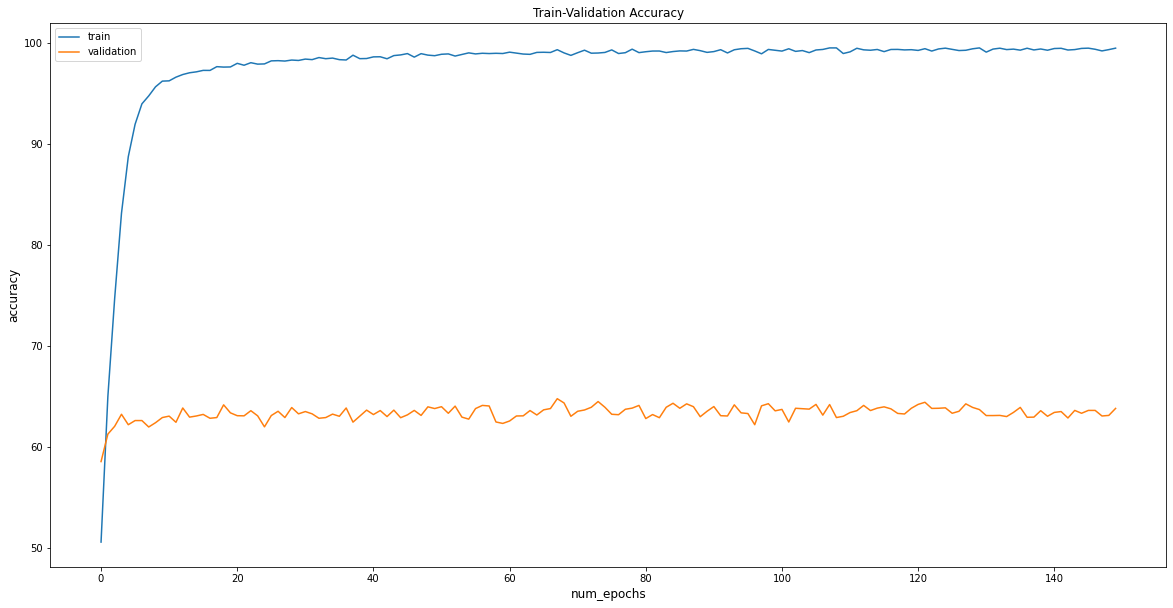

In [8]:
fig = plt.figure(figsize=(20,10))
plt.title("Train-Validation Accuracy")
plt.plot(train_acc, label='train')
plt.plot(val_acc, label='validation')
plt.xlabel('num_epochs', fontsize=12)
plt.ylabel('accuracy', fontsize=12)
plt.legend(loc='best')

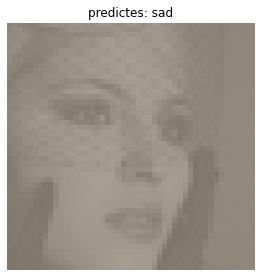

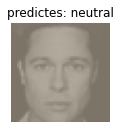

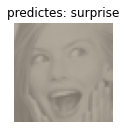

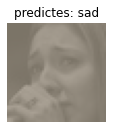

In [9]:
def visualize_model(net, num_images=4):
    images_so_far = 0
    fig = plt.figure(figsize=(15, 10))
    
    for i, data in enumerate(test_dataloader):
        inputs, labels = data
        if device:
            inputs, labels = inputs.cuda(), labels.cuda()
        outputs = net(inputs)
        _, preds = torch.max(outputs.data, 1)
        preds = preds.cpu().numpy() if device else preds.numpy()
        for j in range(inputs.size()[0]):
            images_so_far += 1
            ax = plt.subplot(2, num_images//2, images_so_far)
            ax.axis('off')
            ax.set_title('predictes: {}'.format(test_dataset.classes[preds[j]]))
            imshow(inputs[j])
            
            if images_so_far == num_images:
                return 

plt.ion()
visualize_model(net)
plt.ioff()